In [1]:
#get MNIST data
#first import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import gzip
from keras.datasets import mnist
from skimage.transform import downscale_local_mean




Using TensorFlow backend.


In [2]:
#get the data from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train: ' + str(X_train.shape)) #60000 observations, 28 x 28 matrices
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


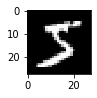

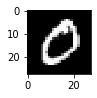

In [3]:
from matplotlib import pyplot
#take a look at a couple of the images for fun
for i in range(2):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [4]:
range(len(X_train))

range(0, 60000)

In [5]:
factors = (2,2) #2x2 blocks 

#initialize downscaled 3dimensional array
X_train_ds = list()
#for each image in the training data set, downscale by calculating the local mean of each 2x2 block and create a new 14x14 image
for i in range(len(X_train)):
    #downscale the bih
    ith_downscaled_image = downscale_local_mean(X_train[i], factors, cval=0, clip=True)
    
    #append it to downscaled training data
    X_train_ds.append(ith_downscaled_image)
    
#make it a 3 d array
X_train_ds = np.array(X_train_ds)

In [6]:
X_train_ds.shape #seems to have worked, X_train_ds is the downscaled version, each element is a 14 by 14 matrix

#for using in (the EM) algorithm, each sample should be treated as a vector (14x14 = 196 dimensional vector)
X_train_vectorized = X_train_ds.reshape(60000,196)

In [39]:
#for our purposes we only want to consider image 5 image classes: {0,1,2,3,4}
#drop the rest

#find the indices from y_train that are 5,6,7,8,9
bool_arr = (y_train >= 5) #find the indices of the images we don't want to cluster/consider
drop_indices = np.where(bool_arr)

#delete them from y_train
y_train_0_4 = np.delete(y_train, drop_indices)

#delete them from X_train as well
X_train_vectorized_0_4 = np.delete(X_train_vectorized, drop_indices, axis = 0) #drop the correct indices row-wise (axis = 0)


**EM Algorithm for Mixture of Spherical Gaussians**

In [ ]:
#Assume 5 clusters